# Column-action method of Cordell (1992) - $\mathtt{C92}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import pickle

# 3D visualization
import pyvista as pv
pv.set_jupyter_backend('panel')

from gravmag import plot_functions as plf
from gravmag import eqlayer as eql
from gravmag import convolve as conv
from gravmag import constants as cts

### Data points

In [2]:
with open('data_points.pickle', 'rb') as f:
    data_points = pickle.load(f)

In [3]:
# number of points along x and y
print(data_points['shape'])

# minimum x, maximum x, minimum y and maximum y
print(data_points['area'])

(50, 50)
[-5000, 5000, -4000, 6000]


In [4]:
# Grid spacing
dx = (data_points['area'][1] - data_points['area'][0])/(data_points['shape'][0]-1)
dy = (data_points['area'][3] - data_points['area'][2])/(data_points['shape'][1]-1)

In [5]:
dx, dy

(204.08163265306123, 204.08163265306123)

In [6]:
# total number of data
D = np.prod(data_points['shape'])

In [7]:
D

2500

In [8]:
data_points['coordinates'][2,0]

-100.0

### Noise-free gravity data

In [9]:
with open('gravity_data.pickle', 'rb') as f:
    gravity_data = pickle.load(f)

### Noise-corrupted gravity data

In [10]:
with open('gravity_data_noisy.pickle', 'rb') as f:
    gravity_data_noisy = pickle.load(f)

### Set the equivalent sources location

In [11]:
# depth of the equivalent layer
Delta_z = 1e-2*dx
z_layer = data_points['coordinates'][2,0] + Delta_z

In [12]:
Delta_z, z_layer

(2.0408163265306123, -97.95918367346938)

In [13]:
data_points['coordinates'][2,0]

-100.0

### Compute the sensitivity matrix

In [14]:
# kernel matrix associated with the equivalent layer
G = cts.GRAVITATIONAL_CONST*cts.SI2MGAL*(
    eql.kernel_matrix_monopoles(data_points['coordinates'], z_layer, field="z", first_column=False)
)

In [15]:
G.shape

(2500, 2500)

In [16]:
sigma = 1/(cts.GRAVITATIONAL_CONST*cts.SI2MGAL)

In [17]:
sigma

149857.63524651583

### Estimate the physical-property distribution with noise-free data

In [18]:
# physical-property distribution
convergence, parameters = eql.method_column_action_C92(
    G=G, data=gravity_data['gz'], data_points=data_points['coordinates'],
    zlayer=z_layer, sigma=sigma, epsilon=1e-3, ITMAX=int(6*D), check_input=True
    )

In [19]:
iterations = [i for i in range(len(convergence))]

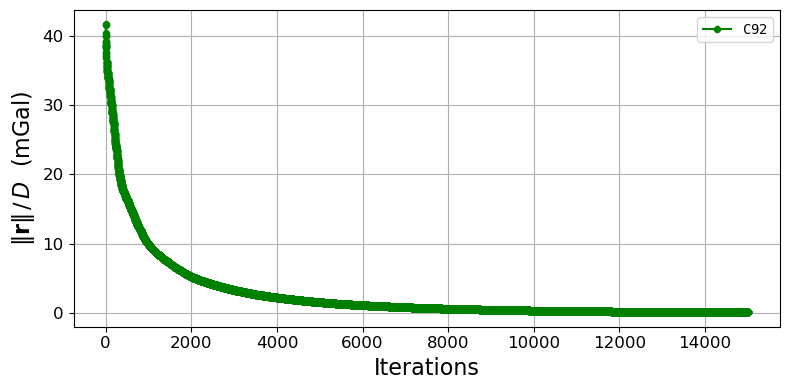

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

# ax.semilogy(iterations, convergence, linestyle='-', 
#             color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')
ax.plot(iterations, convergence, linestyle='-', 
        color='green', marker='8', alpha=1, markersize=4, label='$\mathtt{C92}$')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\Vert \mathbf{r} \Vert \, \slash \, D$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
#plt.savefig('../manuscript/Fig/convergence_C92.png', dpi= 300)
plt.show()

### Estimate the physical-property distribution with noise-corrupted data to produce the numerical stability curve

In [21]:
# define labels for noise levels
levels = [i for i in range(1,21)]

In [22]:
levels

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [23]:
model_perturbations = []
data_perturbations = []

data_norm = np.sqrt(np.sum(gravity_data['gz']*gravity_data['gz']))
parameters_norm = np.sqrt(np.sum(parameters*parameters))

for level in levels:
    data_diff = gravity_data_noisy['d{}'.format(level)] - gravity_data['gz']
    data_perturbation = np.sqrt(np.sum(data_diff*data_diff))/data_norm
    data_perturbations.append(data_perturbation)
    
    # physical-property distribution with noise-corrupted data
    convergence, parameters_noisy = eql.method_column_action_C92(
        G=G, data=gravity_data_noisy['d{}'.format(level)], data_points=data_points['coordinates'],
        zlayer=z_layer, sigma=sigma, epsilon=1e-3, ITMAX=int(6*D), check_input=True
    )
    
    parameters_diff = parameters_noisy - parameters
    model_perturbation = np.sqrt(np.sum(parameters_diff*parameters_diff))/parameters_norm
    model_perturbations.append(model_perturbation)

In [24]:
numerical_stability_curve = dict()
numerical_stability_curve['model'] = model_perturbations
numerical_stability_curve['data'] = data_perturbations

### Plot the numerical stability curve

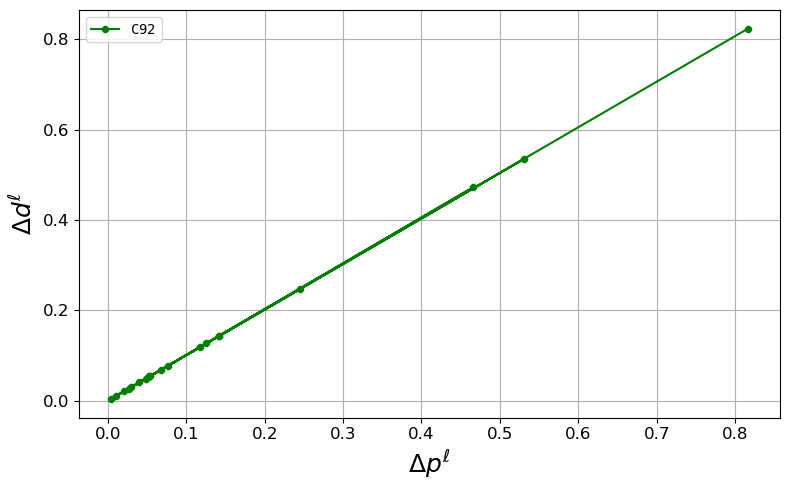

In [26]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(model_perturbations, data_perturbations, linestyle='-', 
        color='green', marker='8', alpha=1, markersize=4, label='$\mathtt{C92}$')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('$\Delta p^{\ell}$', fontsize=18)
ax.set_ylabel('$\Delta d^{\ell}$', fontsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
#plt.savefig('../manuscript/Fig/C92-stability.png', dpi= 300)
plt.show()

### Save the numerical stability curve

In [27]:
file_name = 'C92_stability.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(numerical_stability_curve, f)